<a href="https://colab.research.google.com/github/RaulMrSouza/Bollinger-Buy/blob/master/Bollinger_Buy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import datetime
import pandas_datareader.data as web
from pandas import DataFrame
from datetime import date, timedelta
import numpy as np

/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
df = web.DataReader('SUZB3.SA', 'yahoo', date.today() - timedelta(days=360), date.today())
df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-05-18,45.220001,41.180000,44.799999,41.180000,18094900.0,41.180000
2020-05-19,42.590000,40.380001,40.750000,41.759998,13550700.0,41.759998
2020-05-20,42.450001,39.799999,42.189999,40.250000,10568100.0,40.250000
2020-05-21,40.410000,38.299999,40.240002,38.480000,12789300.0,38.480000
2020-05-22,39.869999,38.000000,38.759998,38.610001,8523700.0,38.610001


In [0]:
#Calculate Bollinger Bands Values
df['20 Day MA'] = df['Close'].rolling(window=20).mean()
df['20 Day STD'] = df['Close'].rolling(window=20).std() 
    
df['Upper'] = df['20 Day MA'] + (df['20 Day STD'] * 2)
df['Lower'] = df['20 Day MA'] - (df['20 Day STD'] * 2)

In [0]:
df = df[20:]
#Set the buy and sell conditions
df['B'] =  ((df['Close'] >=  df['Lower']) & (df['Close'] >  df['Open']) & (df['Close'].shift(periods=1) <  df['Open'].shift(periods=1)) & (df['Close'].shift(periods=1) <  df['Lower'].shift(periods=1))  & (df['Volume'] > df['Volume'].shift(periods=1) )) 
df = df.assign(Buy=np.where(df['B'] , df['Close'], float("NaN")))

df['S'] =  ((df['Close'] <=  df['Upper']) & (df['Close'] <=  df['Open']) & (df['Close'].shift(periods=1) >  df['Open'].shift(periods=1)) & (df['Close'].shift(periods=1) >  df['Upper'].shift(periods=1))  & (df['Volume'] > df['Volume'].shift(periods=1) )) 
df = df.assign(Sell=np.where(df['S'] , df['Close'], float("NaN")))

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style

# Adjusting the size of matplotlib
import matplotlib as mpl
mpl.rc('figure', figsize=(15, 12))

Buy on the <font color='blue'>*Blue*</font> dot and stop operation on the <font color='red'>*Red*</font> dot, assuming markets usually are bullish

Comprar no ponto <font color='blue'>*Azul*</font> e sair da operação no <font color='red'>*Vermelho*</font>, considerando que mercados normalmente se valorizam

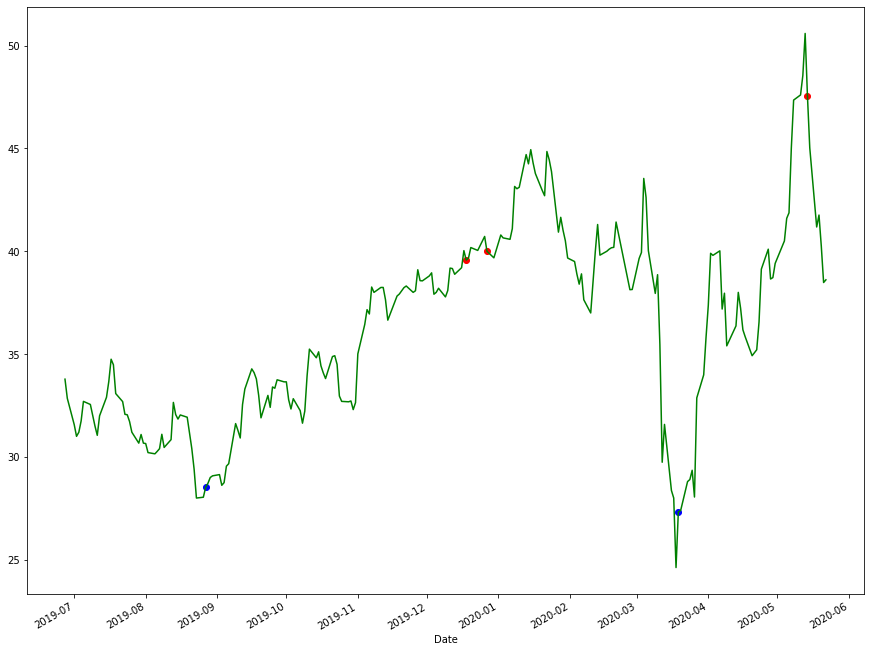

In [6]:
df['Buy'].plot(label='Buy', linestyle='--', marker='o', color='b')
df['Sell'].plot(label='Sell', linestyle='--', marker='o', color='r')
df['Close'].plot(label='Close', color='g')

In [7]:
#set the operations result dataframe
op = df[df['B'] | df['S']]
op = op[op['B'] | op['B'].shift(periods=1)]
op = pd.concat([op, df.tail(1)])
op = op[op['B'] != op['B'].shift(periods=1)]
op['Date'] = op.index
op['BuyDate'] = op['Date'].shift(periods=1)
op['BuyValue'] = op['Close'].shift(periods=1)
op = op.assign(Result=np.where( op['B'] == False & op['B'].shift(periods=1), round(op['Close'] - op['Close'].shift(periods=1), 2), 0))
op = op.rename(columns={'Date':'StopDate', 'Close' : 'StopValue'})
op = op[op['B'] == False]
op[['BuyValue', 'BuyDate', 'StopValue' , 'StopDate', 'Result']]

,BuyValue,BuyDate,StopValue,StopDate,Result
Date,,,,,
2019-12-18,28.52,2019-08-27,39.570000,2019-12-18,11.05
2020-05-14,27.33,2020-03-19,47.540001,2020-05-14,20.21
